# Imports 📚

In [234]:
import pandas as pd
import numpy as np
import requests
from yahoo_fin.stock_info import get_data
import yfinance as yf
import itertools
from dotenv import load_dotenv, find_dotenv
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Data 💾

In [185]:
df = pd.read_excel('../raw_data/raw_lst.xlsx', 
                  index_col=0,
                  header=0)

In [195]:
df = pd.read_csv('../raw_data/raw_stock.csv',
                delimiter=';')

In [196]:
df.head()

,WKN,Herausgeber
0,870747,ODDO
1,A1J4U4,ODDO
2,840400,ODDO
3,865985,ODDO
4,A2DSYC,ODDO


# Translate WKN to ticker ⤵️

In [188]:
### ENV VARIABLES
load_dotenv(find_dotenv())
figi_key = os.environ.get("FIGI")

In [203]:
# openfigi
def translate_wkn(df, figi_key=None):
    '''
    translates the wkn to the intl stock ticker code.
    uses openfigi api to get the info
    takes in a df with a "WKN" column and figi api key.
    if no key provided only 10 requests (rows) can be processed. Else 100 can be processed at a time.
    _____________
    returns enriched df by "ticker" code.
    '''
    # BASE
    openfigi_url = 'https://api.openfigi.com/v1/mapping'
    openfigi_headers = {'Content-Type': 'text/json'}
    
    if figi_key:
        openfigi_headers['X-OPENFIGI-APIKEY'] = figi_key
    
    # DF handle
    df_new = df.copy()
    df_new['ticker'] = None
    jobs = []
    for i, row in df_new.iterrows():
        jobs.append({"idType":"ID_WERTPAPIER","idValue":str(row.WKN), 'exchCode': 'US'})
    
    # REQUEST
    responses = {}
    try:
        r = requests.post(url=openfigi_url, headers=openfigi_headers,
                    json=jobs).json()
    
    except Exception as e:
        print(f'Error: {e}')
    
    for i in range(len(r)):
        try:
            df_new.loc[i,'ticker'] = r[i].get('data')[0].get('ticker')
        except:
            pass
    
    return df_new

In [204]:
df.head()

,WKN,Herausgeber
0,870747,ODDO
1,A1J4U4,ODDO
2,840400,ODDO
3,865985,ODDO
4,A2DSYC,ODDO


In [205]:
re = translate_wkn(df, figi_key=figi_key)

In [207]:
re.head(50)

,WKN,Herausgeber,ticker
0,870747,ODDO,MSFT
1,A1J4U4,ODDO,ASMLF
2,840400,ODDO,ALIZF
3,865985,ODDO,AAPL
4,A2DSYC,ODDO,LIN
5,860180,ODDO,SBGSF
6,710000,ODDO,DDAIF
7,853292,ODDO,LVMHF
8,723610,ODDO,SMAWF
9,716460,ODDO,SAPGF


In [243]:
def history_data(df):
    '''
    searches for historical stock values for designated stocks with the help of yfinance (yahoo).
    takes in a df which contains the column 'ticker'
    ___________
    returns a df with the columns ticker, wkn and the historical values.
    '''
    df_new = df.copy().dropna()
    tickers = ' '.join(df_new.ticker)
    
    yfinance = yf.download(tickers=tickers,
                          period='1y',
                          interval='1d',
                          group_by='ticker')
    
    # do datetime index
    yfinance.index = pd.to_datetime(yfinance.index)
    yfinance = yfinance.T
    
    yfinance['WKN'] = df_new.WKN
    
    # only get the closing price with double indexing
    return yfinance.loc[:,(slice(None), 'Close')]

In [244]:
lala = history_data(re)

[*********************100%***********************]  61 of 61 completed

2 Failed downloads:
- BFASF: No data found for this date range, symbol may be delisted
- WTRWF: No data found for this date range, symbol may be delisted


TypeError: unhashable type: 'slice'

In [242]:
lala

,BFASF,ISSRF,LVMHF,LNXSF,VCISF,MURGF,SAPGF,MDT,RHHVF,ORLY,...,IHIHF,WM,DG,V,CNI,MSFT,DHR,STX,ISSIF,ESLOF
,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,...,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-04,NaN,NaN,440.000000,51.900002,85.269997,271.450012,160.410004,96.290001,347.010010,472.880005,...,NaN,108.820000,195.429993,192.289993,97.410004,213.289993,206.070007,45.389999,NaN,132.000000
2020-08-05,NaN,NaN,447.250000,NaN,NaN,275.649994,160.949997,97.019997,349.750000,468.529999,...,NaN,109.180000,195.279999,196.100006,98.339996,212.940002,205.539993,45.130001,NaN,131.830002
2020-08-06,NaN,NaN,449.670013,NaN,NaN,271.299988,162.699997,96.730003,349.799988,466.070007,...,NaN,110.370003,192.550003,198.770004,99.459999,216.350006,205.690002,44.959999,NaN,131.750000
2020-08-07,NaN,NaN,442.459991,NaN,NaN,272.299988,161.710007,100.050003,342.049988,465.179993,...,NaN,112.720001,195.289993,196.360001,100.080002,212.479996,205.399994,45.310001,NaN,132.000000
2020-08-10,NaN,NaN,437.040009,NaN,94.199997,272.709991,158.500000,100.379997,344.709991,461.149994,...,NaN,111.610001,193.289993,196.789993,101.449997,208.250000,202.050003,46.070000,NaN,132.350006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-29,NaN,NaN,813.969971,NaN,106.000000,NaN,144.929993,130.679993,382.170013,596.320007,...,NaN,146.210007,233.000000,247.919998,107.480003,286.500000,297.630005,87.199997,NaN,184.479996
2021-07-30,NaN,NaN,814.099976,NaN,106.000000,272.000000,142.399994,131.309998,389.000000,603.840027,...,NaN,148.259995,232.639999,246.389999,108.629997,284.910004,297.489990,87.900002,NaN,187.380005


<AxesSubplot:xlabel='Date'>

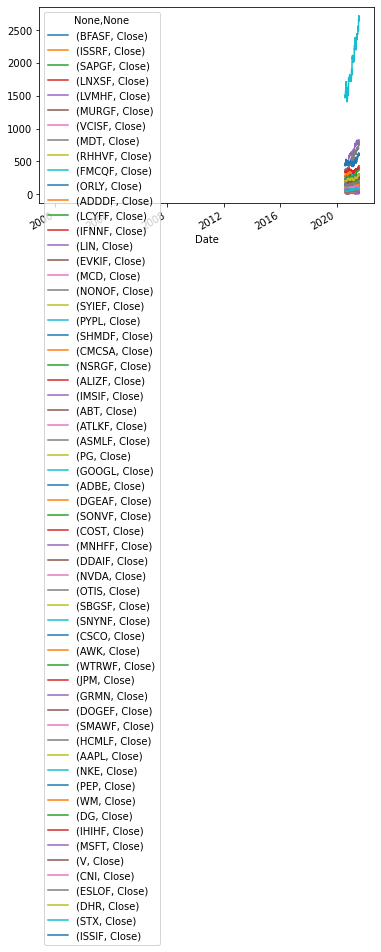

In [223]:
lala.loc[:,'Close', :].T.plot()